In [1]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt

from multi_mems import *

ver()

This is multi_mems version 1.05


### Prepare the 2D Potential Landscape for the Simulation

In [2]:
xmin,xmax = -180,180
n_dim = 2
bins1 = np.linspace(xmin,xmax,200)

bins2 = np.linspace(xmin,xmax,200)
x1max=180
x2max=180
x1min=-180
x2min=-180


fe_2d =  np.loadtxt('fe_pentane.txt', delimiter = ',')
fe_2d=fe_2d
pos_2d = np.zeros((len(bins1)-1,2))

pos_2d.T[0] +=(bins1[1:]+bins1[:-1])/2
pos_2d.T[1] +=(bins2[1:]+bins2[:-1])/2

pos_ana,fe_ana,du_func, pos_fine,force_matrix  = get_du_nd(pos_2d,fe_2d,n_dim = n_dim,bounds=False,degrees=3)
force_min = np.min(force_matrix)
force_max = np.max(force_matrix)

### Set the Parameters (Dummy Values)

In [3]:
nsteps=int(5e6)
kT=2.494
dt=2e-3
trunc = 100*dt/0.002
n_dim=2
uncorr_fr = False
kT = 2.494
sym=True

gamma = 4e-3 #4e-4
gammas = np.array([[gamma,-gamma/10],[-gamma/10,gamma]])
tau = 1
taus = np.array([[tau,-tau/100],[-tau/100,tau]])
ks = np.dot(gammas,np.linalg.inv(taus))

gammas = gammas.reshape(1,2,2) #shape required, increase the first dimensional for a multi-exponential simulation
taus = taus.reshape(1,2,2)
ks = ks.reshape(1,2,2)
n_exp = len(gammas)
print(n_exp)

m = 3e-5
mass = np.array([[m,-m/20],[-m/20,m]])


1


### Run the Simulation

In [4]:
#generate initial condition
v0 = np.zeros([n_dim,])
y0 = np.zeros([n_exp,n_dim,])
x0 = np.zeros([n_dim,])
x0[0] = 0
x0[1] = 0
v0[0]=random.gauss(0.0,math.sqrt(kT/mass[0][0]))
v0[1]=random.gauss(0.0,math.sqrt(kT/mass[1][1]))

for j in range(n_exp):
    y0[j][0]=random.gauss(x0[0],math.sqrt(kT*np.absolute(np.dot(np.linalg.inv(gammas[j]),taus[j]))[0][0]))
    y0[j][1]=random.gauss(x0[1],math.sqrt(kT*np.absolute(np.dot(np.linalg.inv(gammas[j]),taus[j]))[1][1]))

#perform the RK4 simulation
x,vv,yy = integrate_gle_multi_dim_exp(x0,v0, y0,ks, gammas, 
                                      mass,nsteps, dt, kT,force_matrix = force_matrix,
                                      force_bins = pos_fine,force_max = force_max,
                                      force_min = force_min,x1max=x1max,x2max=x2max,
                                      x1min=x1min,x2min=x2min,uncorr_fr = uncorr_fr)

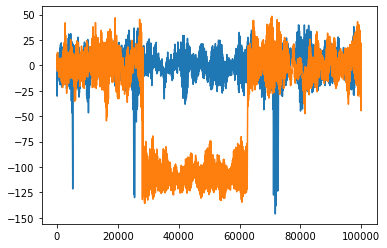

In [5]:
plt.plot(x.T[1][:100000])
plt.plot(x.T[0][:100000])

### Check the Simulation by the Computation of the Potential of Mean Force

#### 1D Landscape

<ipython-input-6-1c4ce89d3613>:4: RuntimeWarning: divide by zero encountered in log
  fe_sim_1d = -np.log(hist_1d)*kT


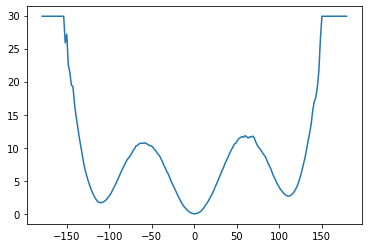

In [6]:
hist,edges=np.histogram(x.T[0], bins=bins1, density=True)
pos_1d =(edges[1:]+edges[:-1])/2
hist_1d = hist
fe_sim_1d = -np.log(hist_1d)*kT
fe_sim_1d[np.where(fe_sim_1d == np.inf)] = np.nanmax(fe_sim_1d[fe_sim_1d != np.inf])
fe_sim_1d -=np.min(fe_sim_1d)

plt.plot(pos_1d,fe_sim_1d)

#### 2D Landscape

simulated


<ipython-input-7-028c5b4046fa>:8: RuntimeWarning: divide by zero encountered in log
  fe_sim_2d = -np.log(hist_2d)*kT


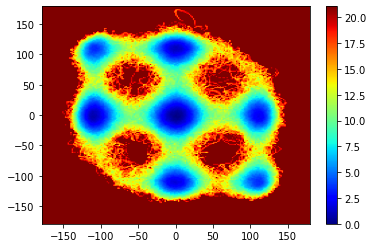

reference


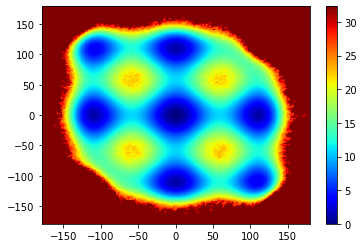

difference


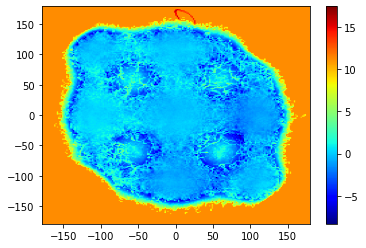

In [7]:
hist=np.histogramdd(np.stack([x.T[0],x.T[1]], axis=1), bins=(bins1,bins2), density=True)

pos_2d_sim = np.zeros((len(bins1)-1,2))
    
for z in range(n_dim):
        pos_2d_sim.T[z] +=(hist[1][z][1:]+hist[1][z][:-1])/2
hist_2d = hist[0] 
fe_sim_2d = -np.log(hist_2d)*kT
fe_sim_2d[np.where(fe_sim_2d == np.inf)] = np.nanmax(fe_sim_2d[fe_sim_2d != np.inf])

fe_sim_2d -=np.min(fe_sim_2d)

print('simulated')
plt.imshow((fe_sim_2d.T), aspect='auto',
           cmap=plt.cm.jet, extent = [np.min(pos_2d.T[0]) , np.max(pos_2d.T[0]), np.min(pos_2d.T[1]) , np.max(pos_2d.T[1])])
plt.colorbar()
plt.show()

print('reference')
plt.imshow((fe_2d.T), aspect='auto',
           cmap=plt.cm.jet, extent = [np.min(pos_2d.T[0]) , np.max(pos_2d.T[0]), np.min(pos_2d.T[1]) , np.max(pos_2d.T[1])])
plt.colorbar()
plt.show()

print('difference')
plt.imshow((fe_2d-fe_sim_2d).T, aspect='auto',
           cmap=plt.cm.jet, extent = [np.min(pos_2d.T[0]) , np.max(pos_2d.T[0]), np.min(pos_2d.T[1]) , np.max(pos_2d.T[1])])
plt.colorbar()
plt.show()
